In [2]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

/Users/benmagevney/miniconda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# read datasets 
enc = pd.read_csv('../../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../../data/regional_datasets/univariate/wsc_data_univ.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    


In [5]:
# ignore values before march 
enc = enc[enc.index >= "2020-03-01"]
esc = esc[esc.index >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.index >= "2020-03-01"]
mountain = mountain[mountain.index >= "2020-03-01"]
new_england = new_england[new_england.index >= "2020-03-01"]
pacific = pacific[pacific.index >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.index >= "2020-03-01"]
wnc = wnc[wnc.index >= "2020-03-01"]
wsc = wsc[wsc.index >= "2020-03-01"]

# ARIMA

In [26]:
def build_arima_model(df, params=None, plot=False, test_perf = False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])

    if not params:
        params = (4,1,4)

    # validation step
    
    model = ARIMA(train, order=params)
    model_fit = model.fit()

    val_pred = model_fit.forecast(steps=len(val))
    
    mae = round(mean_absolute_error(val, val_pred), 2)
    rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
    aic = round(model_fit.aic, 2)

    print(f"Validatation Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot and not test_perf:
        plt.figure(figsize=(15, 5))
        plt.title(f'Validation ARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val')
        plt.plot(val_pred.index, val_pred, label='Predicted')
        plt.legend() 
        plt.show()

    # test 
    if test_perf:
        model = ARIMA(train_val, order=params)
        model_fit = model.fit()

        test_pred = model_fit.forecast(steps=len(test))
        mae = round(mean_absolute_error(test, test_pred), 2)
        rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
        mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
        aic = round(model_fit.aic, 2)

        print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
        
        # plot both validation and test
        # if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'ARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val', color="#1f77b4")
        plt.plot(val_pred.index, val_pred, label='Val Predicted', color="purple")
        plt.plot(test.index, test, label='True Test', color="#1f77b4")
        plt.plot(test_pred.index, test_pred, label='Test Predicted', color="#ff7f0e")
        plt.legend() 
        plt.show()

    print(f"Training for {region} complete")

Training model for East North Central...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 16901.12, MASE: 0.91, RMSE: 11329.75, MAE: 7473.34
Test Stats= AIC: 18956.86, MASE: 1.06, RMSE: 10928.54, MAE: 8650.4


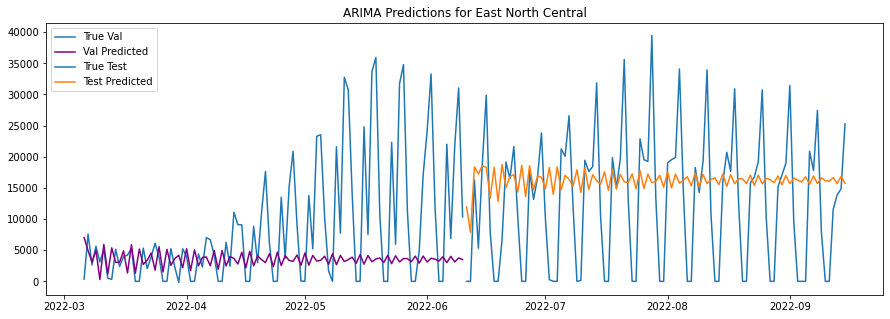

Training for East North Central complete

Training model for East South Central...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 15649.23, MASE: 0.58, RMSE: 2881.62, MAE: 1967.73
Test Stats= AIC: 17522.98, MASE: 1.63, RMSE: 6991.96, MAE: 5312.39


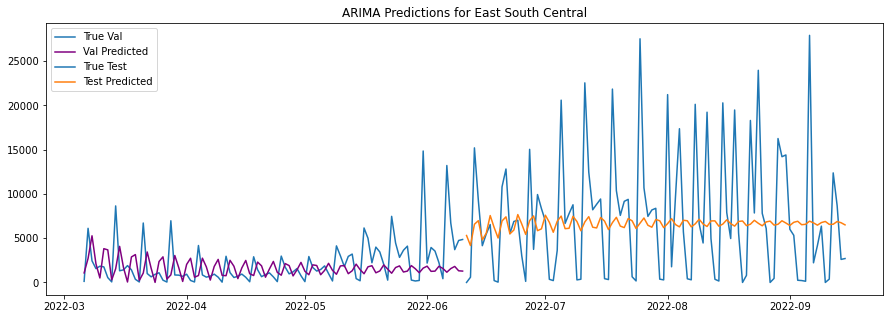

Training for East South Central complete

Training model for Mid-Atlantic...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 15235.0, MASE: 3.47, RMSE: 10204.81, MAE: 7419.07
Test Stats= AIC: 17171.18, MASE: 3.18, RMSE: 9499.57, MAE: 7528.19


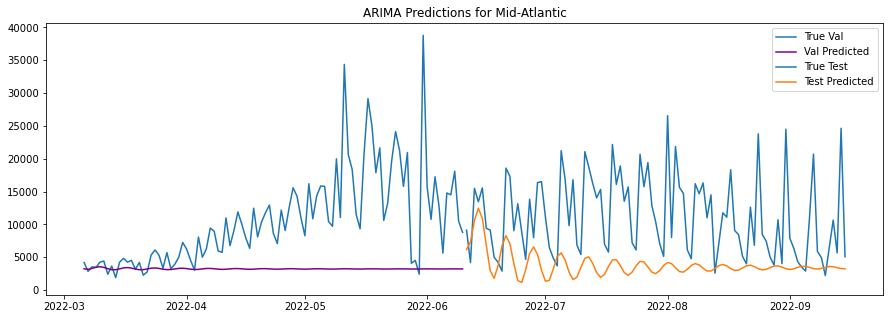

Training for Mid-Atlantic complete

Training model for Mountain...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 15727.43, MASE: 1.62, RMSE: 6226.04, MAE: 5111.17
Test Stats= AIC: 17590.8, MASE: 2.58, RMSE: 9390.85, MAE: 8232.46


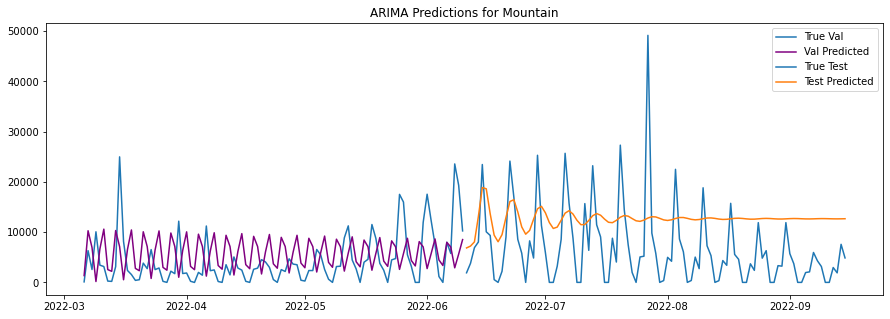

Training for Mountain complete

Training model for New England...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 15394.43, MASE: 1.35, RMSE: 5122.4, MAE: 3417.41
Test Stats= AIC: 17265.24, MASE: 0.88, RMSE: 3249.18, MAE: 2304.52


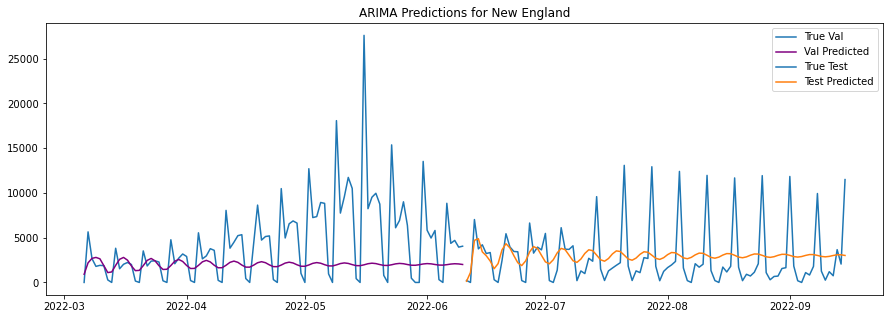

Training for New England complete

Training model for Pacific...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 17037.88, MASE: 1.42, RMSE: 14339.75, MAE: 9635.32
Test Stats= AIC: 19151.43, MASE: 2.68, RMSE: 22296.36, MAE: 19977.18


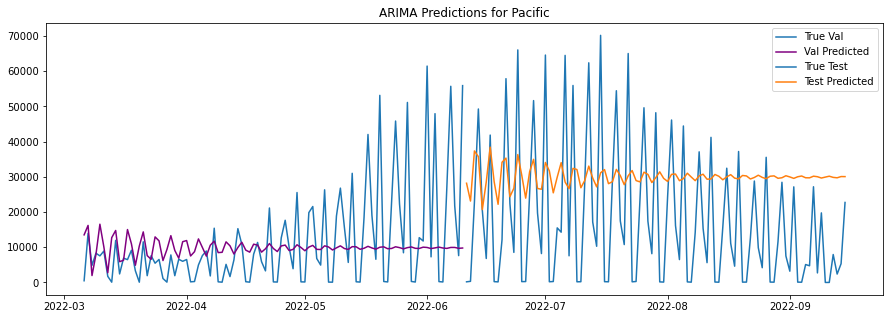

Training for Pacific complete

Training model for South Atlantic...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 17612.62, MASE: 0.88, RMSE: 15529.41, MAE: 9532.93
Test Stats= AIC: 19747.99, MASE: 1.7, RMSE: 22195.73, MAE: 18174.93


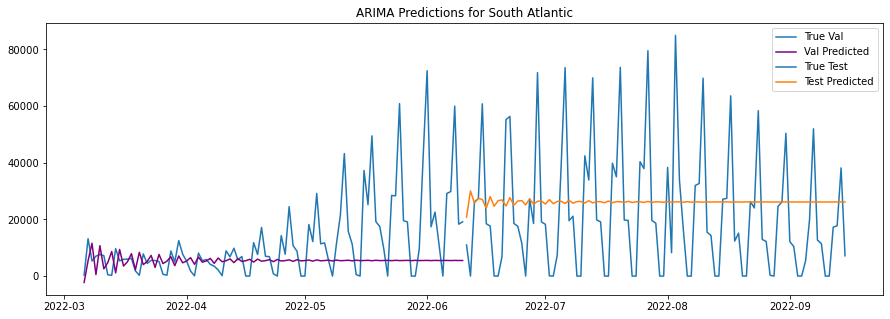

Training for South Atlantic complete

Training model for West North Central...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 15536.62, MASE: 0.99, RMSE: 3646.77, MAE: 3251.49
Test Stats= AIC: 17399.49, MASE: 1.31, RMSE: 4538.8, MAE: 4084.55


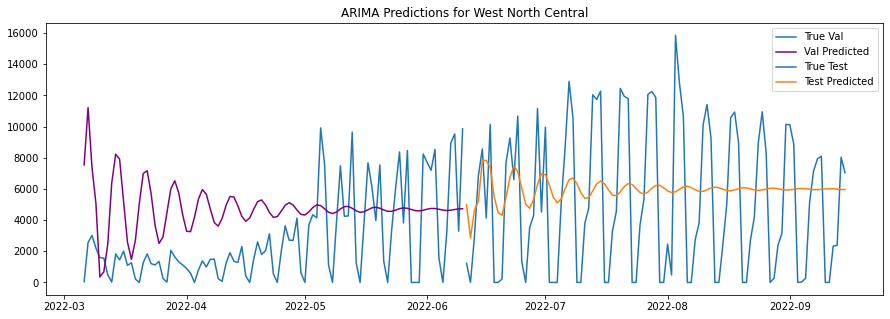

Training for West North Central complete

Training model for West South Central...
2020-01-22 00:00:00 2022-03-05 00:00:00
2022-03-06 00:00:00 2022-06-10 00:00:00
2022-06-11 00:00:00 2022-09-15 00:00:00
Validatation Stats= AIC: 16446.11, MASE: 0.59, RMSE: 3442.85, MAE: 2680.98
Test Stats= AIC: 18415.33, MASE: 1.77, RMSE: 9565.22, MAE: 7584.54


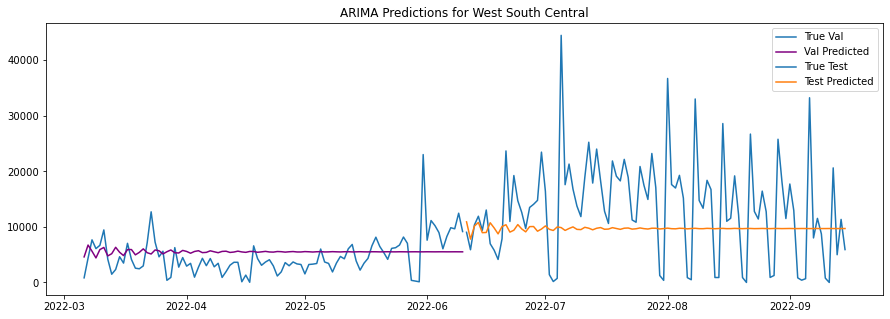

Training for West South Central complete

--- 18.79 seconds ---


In [25]:
start_time = time.time()
for df in datasets:
    build_arima_model(df, plot=True, test_perf=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Optimization

In [4]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    # Splitting the data into train and test sets without shuffling
    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

    train = train_df['new_confirmed']

    tscv = TimeSeriesSplit(n_splits=5)
    results = []

    for train_index, val_index in tscv.split(train):
        train_data, val_data = train.iloc[train_index], train.iloc[val_index]
        
        for p in range(5, 8):
            for d in range(2):
                for q in range(5, 8):
                    try:
                        model = ARIMA(train_data, order=(p,d,q))
                        model_fit = model.fit()

                        val_pred = model_fit.forecast(steps=len(val_data))
                        mae = mean_absolute_error(val_data, val_pred)
                        rmse = np.sqrt(mean_squared_error(val_data, val_pred))
                        mase = mean_absolute_scaled_error(val_data, val_pred, y_train=train_data)

                        results.append([p, d, q, model_fit.aic, mae, rmse, mase])
                        # print([p, d, q, model_fit.aic, mae, rmse, mase])
                    except:
                        continue  # Skip this combination if the model fails to fi

    results_df = pd.DataFrame(results, columns=["p", "d", "q", "aic", "mae", "rmse", "mase"])
    
    # Aggregating the results by taking the mean of the metrics for each parameter combination
    aggregated_results = results_df.groupby(["p", "d", "q"]).mean().reset_index()
    
    
    best_results = aggregated_results.sort_values(by="mase")
    
    print(best_results.head())


In [6]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for East North Central...
    p  d  q          aic           mae          rmse       mase
16  7  1  6  6982.954622  12035.333637  18227.537400  10.328787
3   5  1  5  7056.676994  12209.724045  18246.101883  10.643855
15  7  1  5  6985.651253  12241.418127  18438.527141  10.724529
0   5  0  5  7146.893061  12120.350335  17988.017502  10.724555
4   5  1  6  7050.338045  12247.419032  18261.521007  10.739680

Optimizing model for East South Central...
    p  d  q          aic          mae         rmse      mase
11  6  1  7  6790.221655  6605.106570  9744.704952  9.337044
5   5  1  7  6794.041918  6638.081589  9772.836613  9.405205
16  7  1  6  6785.374468  6734.852818  9874.060139  9.435097
17  7  1  7  6789.915749  6701.122900  9849.819934  9.451376
10  6  1  6  6790.088328  6711.819767  9850.787080  9.453827

Optimizing model for Mid-Atlantic...
    p  d  q          aic           mae          rmse       mase
14  7  0  7  6716.728144  10767.576972  15526.857988  12.6907

## Final ARIMA

In [6]:

params = {
    "East North Central": (7, 1, 6),
    "East South Central": (6, 1, 7),
    "Mid-Atlantic": (7, 0, 7),
    "Mountain": (7, 1, 5),  
    "New England": (5, 1, 5),
    "Pacific": (6, 0, 5),
    "South Atlantic": (7, 1, 5),
    "West North Central": (5, 1, 7),
    "West South Central": (5, 1, 6),
}

In [7]:
def final_arima_model(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
    # val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    

    if not params:
        params = (4,1,4)

    # validation step
    
    model = ARIMA(train, order=params)
    model_fit = model.fit()

    test_pred = model_fit.forecast(steps=len(test))

    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train), 2)
    aic = round(model_fit.aic, 2)
    

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Test ARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True Test')
        plt.plot(test_pred.index, test_pred, label='Predicted')
    
        plt.legend() 
        plt.show()



Training model for East North Central...
Test Stats= AIC: 16410.14, MASE: 1.26, RMSE: 14513.38, MAE: 10310.57


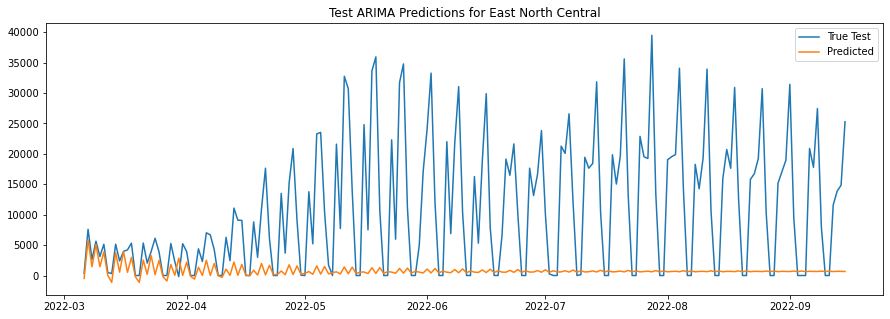


Training model for East South Central...
Test Stats= AIC: 15528.86, MASE: 1.2, RMSE: 6071.14, MAE: 4102.45


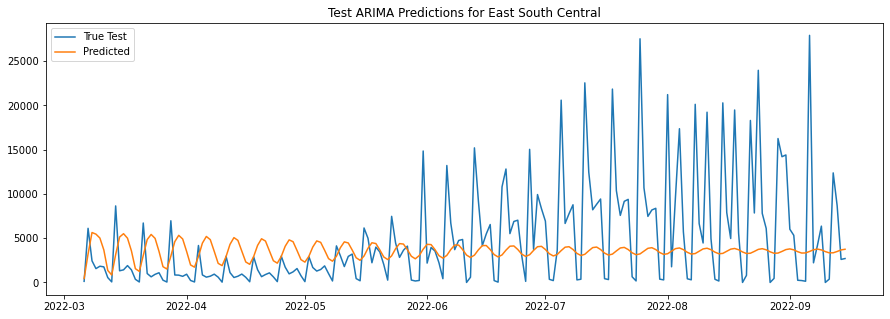


Training model for Mid-Atlantic...
Test Stats= AIC: 15208.3, MASE: 2.3, RMSE: 6118.88, MAE: 4922.85


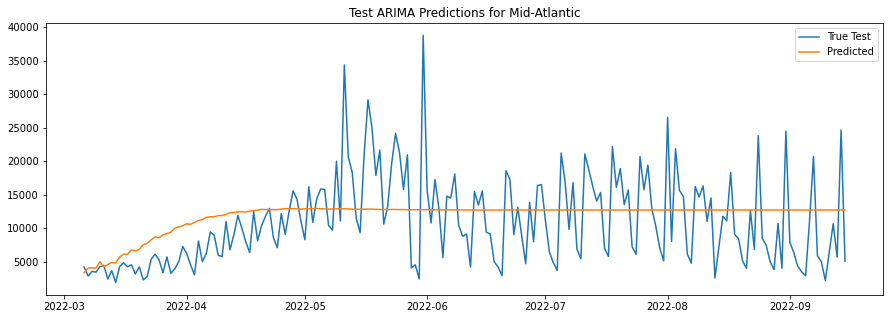


Training model for Mountain...
Test Stats= AIC: 15580.87, MASE: 1.48, RMSE: 7821.08, MAE: 4654.85


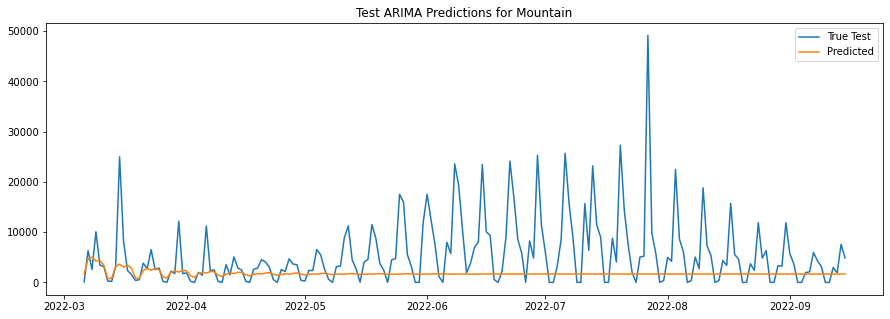


Training model for New England...
Test Stats= AIC: 15324.51, MASE: 1.11, RMSE: 4491.88, MAE: 2817.88


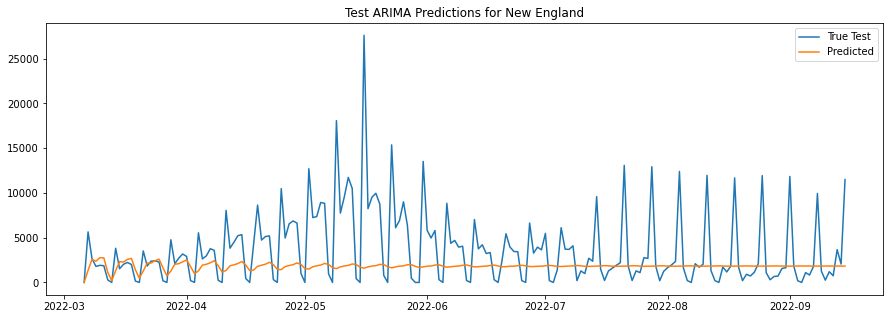


Training model for Pacific...
Test Stats= AIC: 16812.01, MASE: 1.86, RMSE: 17350.24, MAE: 12565.83


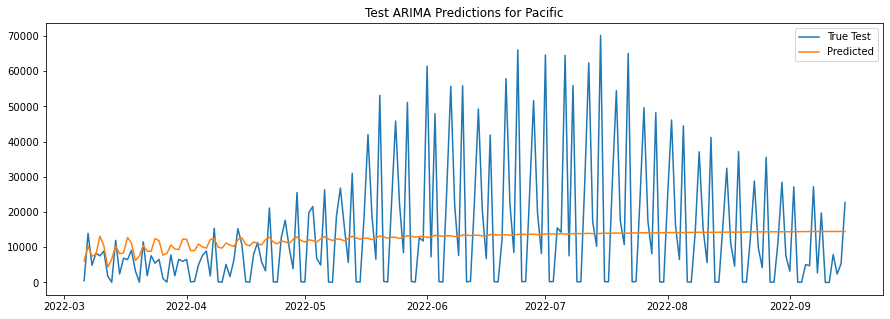


Training model for South Atlantic...
Test Stats= AIC: 17380.56, MASE: 1.41, RMSE: 23616.04, MAE: 15279.01


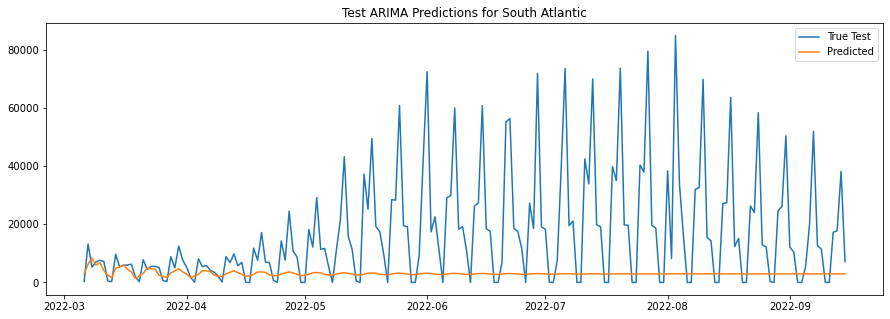


Training model for West North Central...
Test Stats= AIC: 15431.45, MASE: 1.16, RMSE: 4358.19, MAE: 3797.03


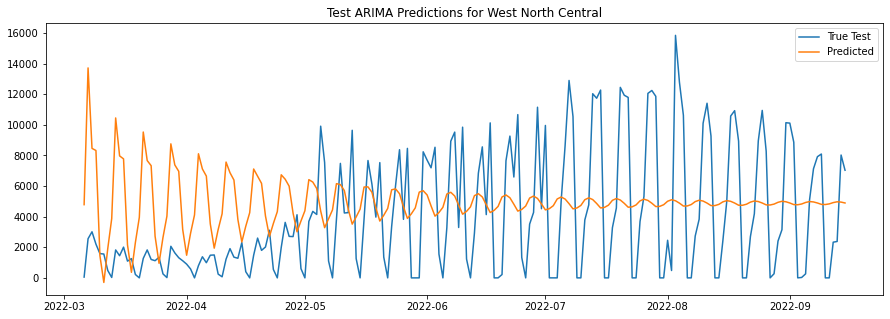


Training model for West South Central...
Test Stats= AIC: 16354.24, MASE: 1.6, RMSE: 10462.11, MAE: 7277.45


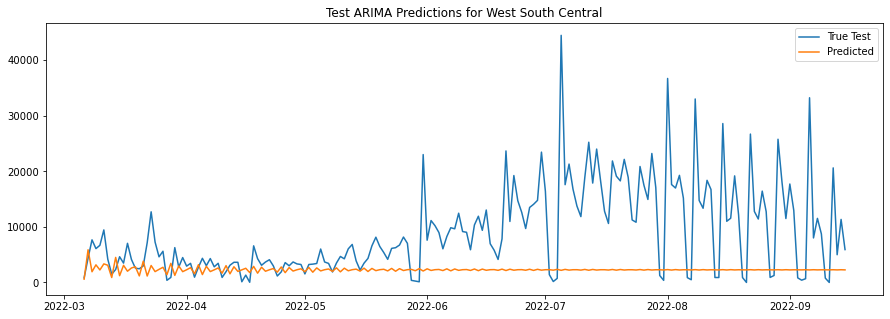


--- 43.07 seconds ---


In [8]:
start_time = time.time()
for df in datasets:
    final_arima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Sarimax

In [20]:
def build_sarima_model(df, params=None, seasonal_params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    if params and seasonal_params:
         model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
    elif params:
        model = SARIMAX(train, order=params, seasonal_order=(1, 1, 1,7))
    else:
        model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1,7))
    model_fit = model.fit(disp=False)

    pred = model_fit.forecast(steps=size)    

    # calculate metrics
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = mean_squared_error(test, pred, squared=False)
    mase = mean_absolute_scaled_error(test, pred, y_train=train)
    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'SARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True')
        plt.plot(pred.index, pred, label='Predicted')
        plt.legend() 
        plt.show()



Training model for East North Central...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 7925.06
MSE: 106508863.0
RMSE: 10320.31
MASE: 1.0


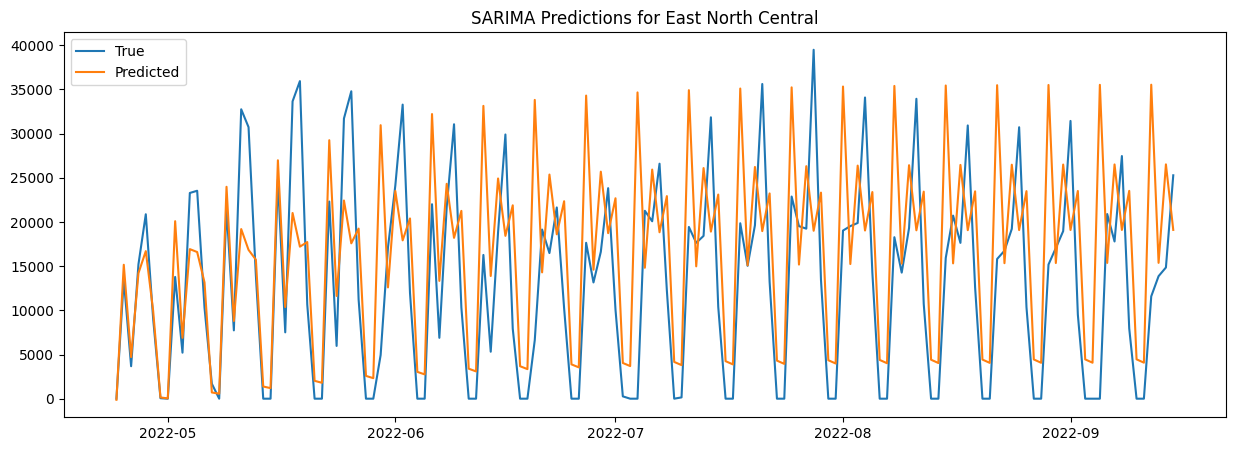


Training model for East South Central...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 3348.06
MSE: 26481706.55
RMSE: 5146.04
MASE: 1.01


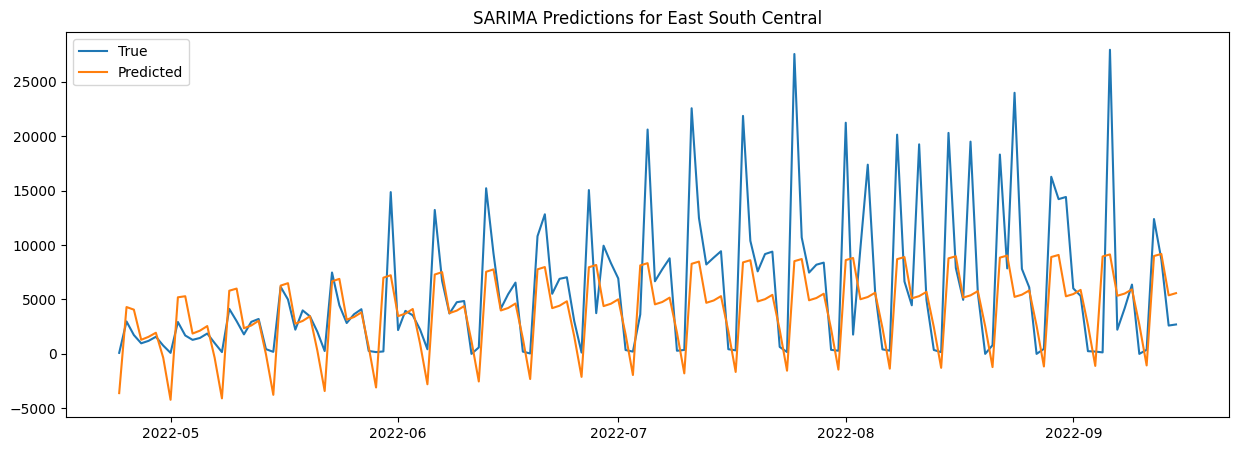


Training model for Mid-Atlantic...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 5868.39
MSE: 66779579.78
RMSE: 8171.88
MASE: 2.76


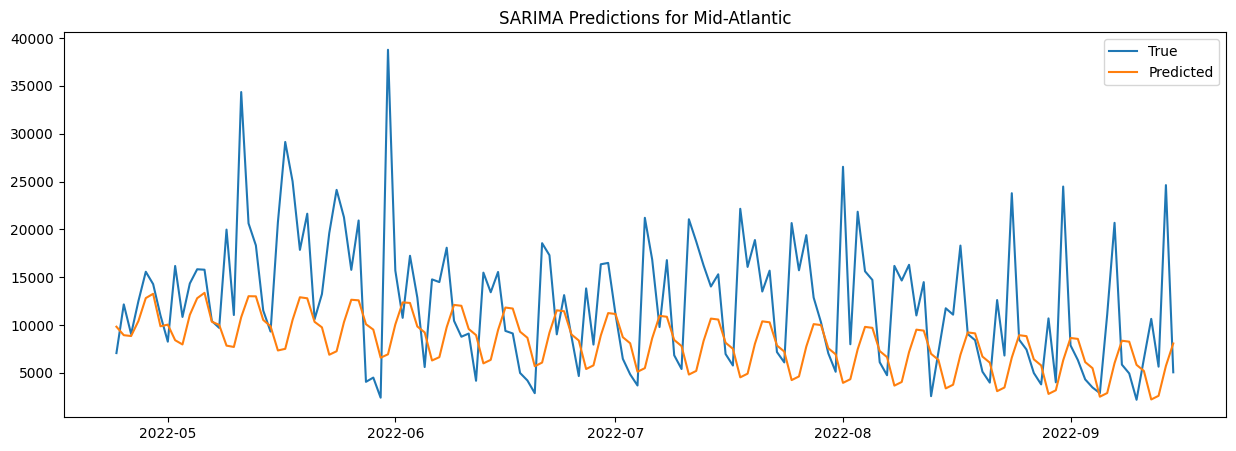


Training model for Mountain...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 9291.88
MSE: 128928335.44
RMSE: 11354.66
MASE: 2.94


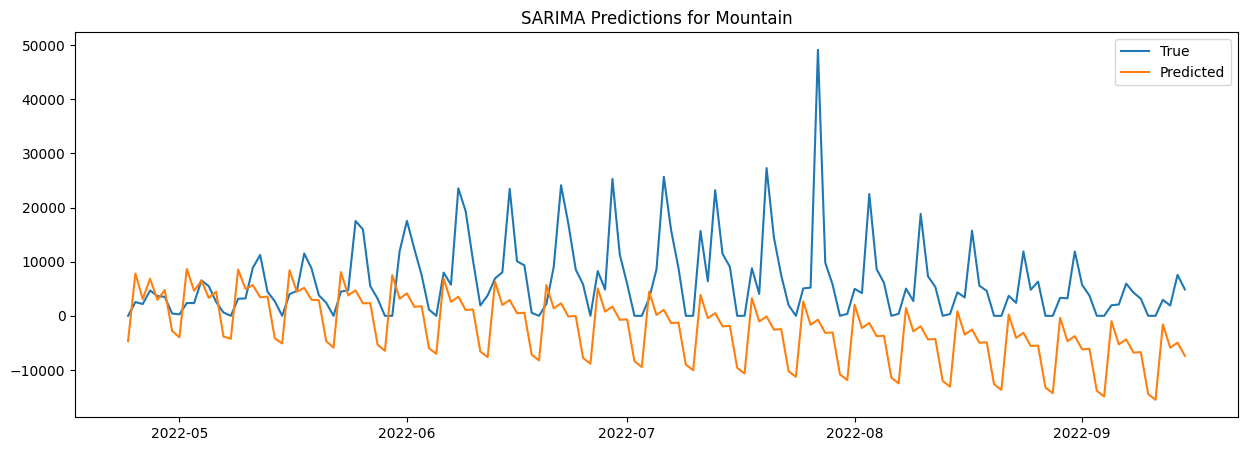


Training model for New England...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 6285.63
MSE: 56208775.37
RMSE: 7497.25
MASE: 2.52


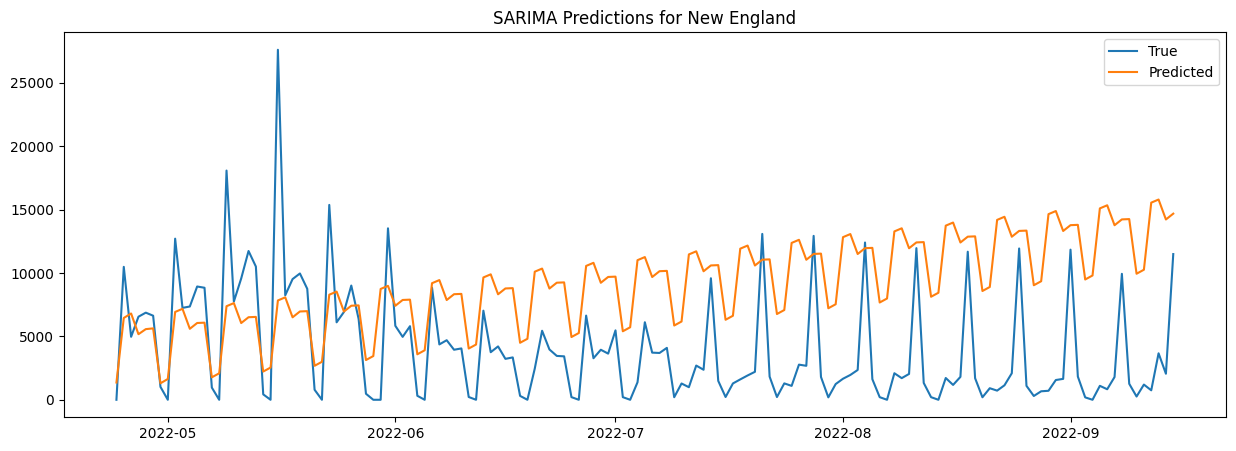


Training model for Pacific...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 12413.99
MSE: 284268746.36
RMSE: 16860.27
MASE: 1.85


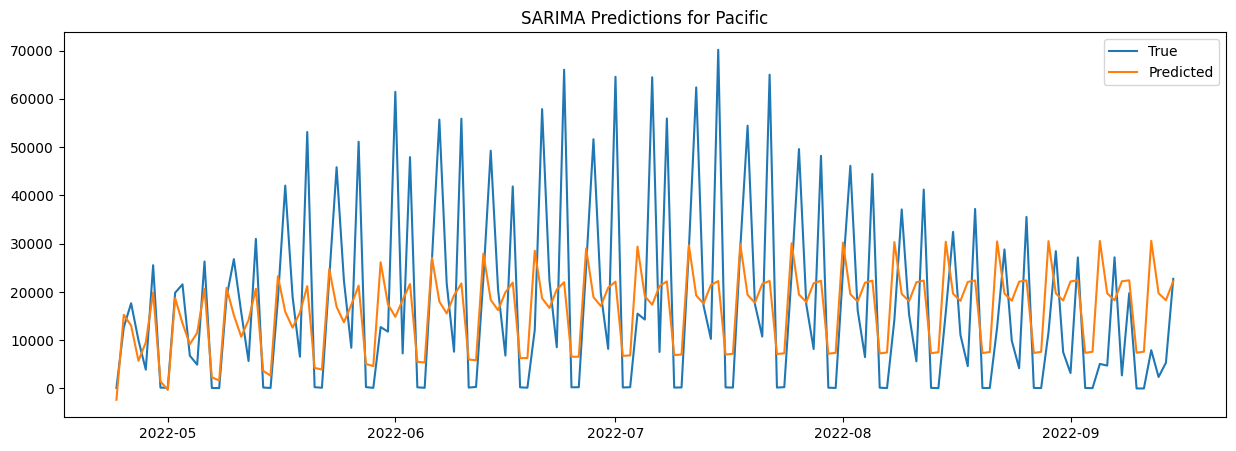


Training model for South Atlantic...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 14854.8
MSE: 464059369.22
RMSE: 21542.04
MASE: 1.43


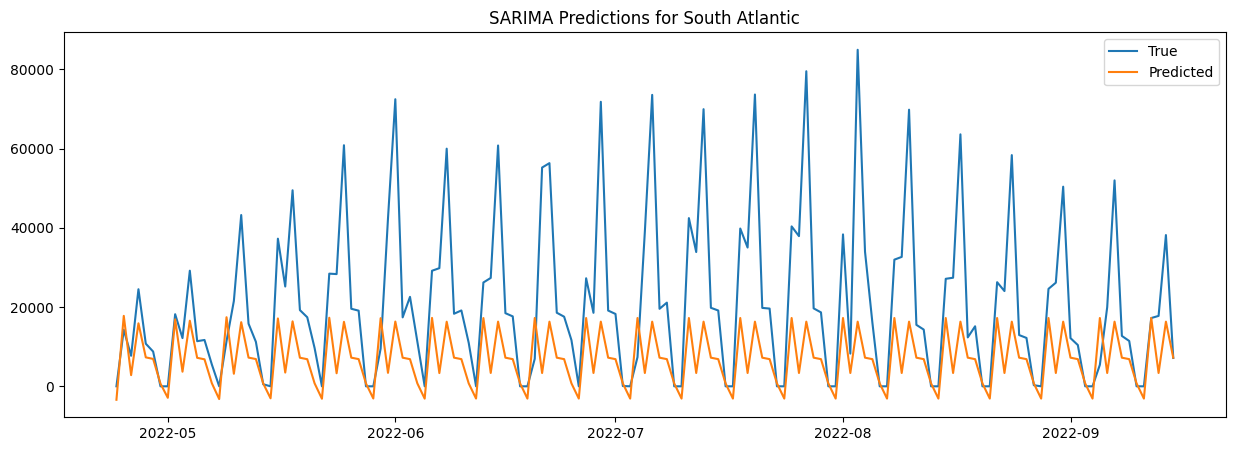


Training model for West North Central...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 3751.08
MSE: 22222288.89
RMSE: 4714.05
MASE: 1.2


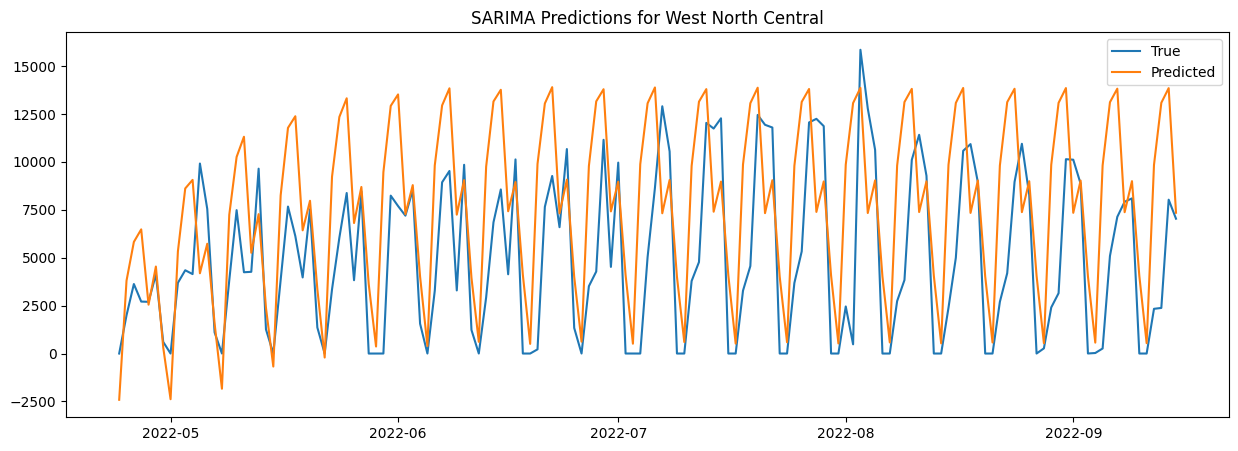


Training model for West South Central...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MAE: 5828.22
MSE: 55313138.46
RMSE: 7437.28
MASE: 1.32


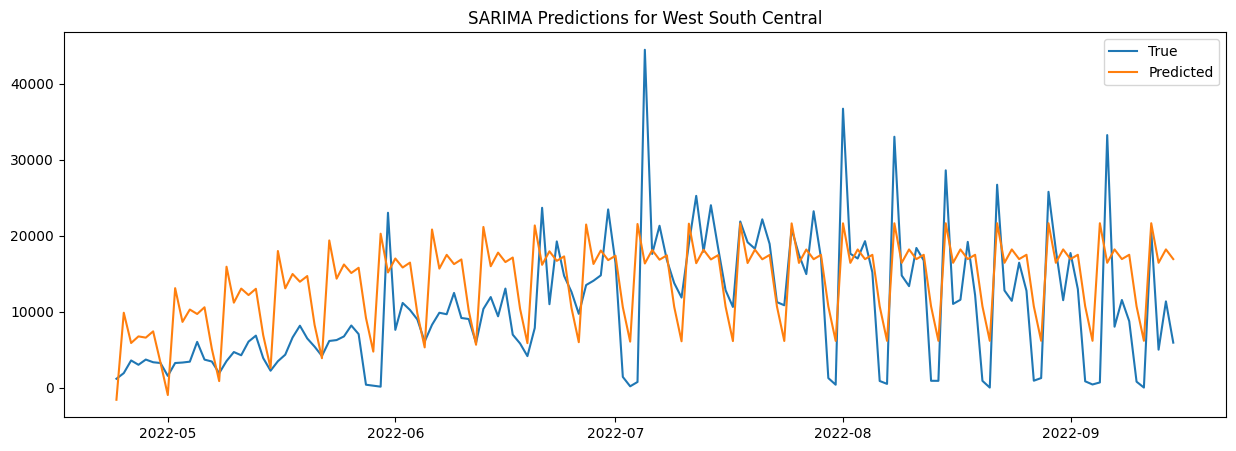


--- 77.85 seconds ---


In [21]:
start_time = time.time()
for df in datasets:
    build_sarima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

In [21]:
def sarima_parameter_tune(df, params, D=0):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    results = []
    # for p in range(1, 3):
    #     # for d in range(2):
    #     for q in range(1, 3):
    for P in range(1, 4):
        for Q in range(1, 4):
            model = SARIMAX(train, order=params, seasonal_order=(P, D, Q, 7))
            model_fit = model.fit(disp=False)

            # pred = model_fit.forecast(steps=size)

            # # calculate metrics
            # mae = mean_absolute_error(test, pred)
            # rmse = mean_squared_error(test, pred, squared=False)
            # mase = mean_absolute_scaled_error(test, pred, y_train=train)

            results.append([P, Q, model_fit.aic])
                
    results = pd.DataFrame(results, columns=["P", "Q", "aic"])
    results.sort_values(by="aic", inplace=True)
    print(results.head())

In [22]:
start_time = time.time()
for df in datasets:
    sarima_parameter_tune(df, params[df["region"].iloc[0]])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
   P  Q           aic
6  3  1  17366.629673
7  3  2  17369.257858
8  3  3  17371.404446
5  2  3  17373.571153
1  1  2  17373.824085

Training model for East South Central...
   P  Q           aic
0  1  1  16469.770465
3  2  1  16471.502553
1  1  2  16471.551594
2  1  3  16472.460177
6  3  1  16472.490432

Training model for Mid-Atlantic...
   P  Q           aic
5  2  3  16110.762214
7  3  2  16111.628827
6  3  1  16112.208593
8  3  3  16112.428438
2  1  3  16113.361546

Training model for Mountain...
   P  Q           aic
5  2  3  16498.947711
7  3  2  16499.137429
6  3  1  16503.407263
8  3  3  16503.432199
4  2  2  16507.941077

Training model for New England...
   P  Q           aic
3  2  1  16159.067628
4  2  2  16159.636379
2  1  3  16160.957812
5  2  3  16161.317436
1  1  2  16161.507401

Training model for Pacific...
   P  Q           aic
1  1  2  17574.338725
8  3  3  17575.723249
4  2  2  17575.762956
2  1  3  17577.768049
5  2  3  1757

In [31]:
start_time = time.time()
for df in datasets:
    sarima_parameter_tune(df, params[df["region"].iloc[0]], D=1)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector

## Final SARIMA

In [23]:
# seasonal_params = {
#     "East North Central": (3, 1, 2, 7),
#     "East South Central": (2, 1, 3, 7),
#     "Mid-Atlantic": (1, 0, 1, 7),
#     "Mountain": (1, 0, 2, 7),
#     "New England": (3, 0, 2, 7),
#     "Pacific": (2, 1, 2, 7),
#     "South Atlantic": (1, 1, 3, 7),
#     "West North Central": (1, 1, 1, 7),
#     "West South Central": (3, 0, 3, 7),
# }
# D = 0
seasonal_params = {
    "East North Central": (3, 0, 1, 7),
    "East South Central": (1, 0, 1, 7),
    "Mid-Atlantic": (2, 0, 3, 7),
    "Mountain": (2, 0, 3, 7),
    "New England": (2, 0, 1, 7),
    "Pacific": (1, 0, 2, 7),
    "South Atlantic": (1, 0, 3, 7),
    "West North Central": (1, 0, 3, 7),
    "West South Central": (2, 0, 3, 7),
}

Training model for East North Central...
MAE: 8153.91
MSE: 99891763.79
RMSE: 9994.59
MASE: 1.03


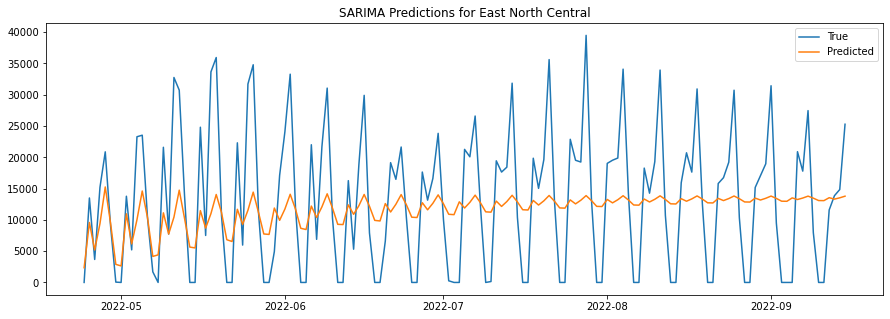


Training model for East South Central...
MAE: 5245.94
MSE: 61602587.76
RMSE: 7848.73
MASE: 1.58


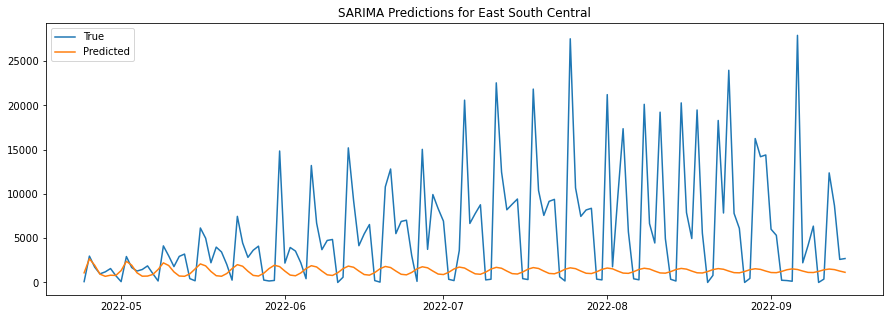


Training model for Mid-Atlantic...
MAE: 5395.65
MSE: 44976995.6
RMSE: 6706.49
MASE: 2.54


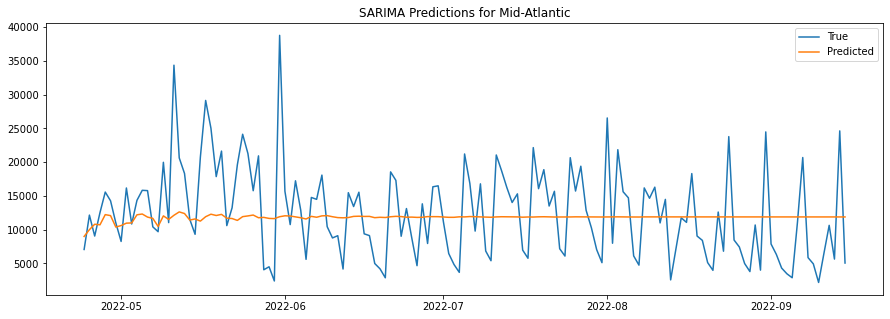


Training model for Mountain...
MAE: 6956.87
MSE: 91164757.89
RMSE: 9548.02
MASE: 2.2


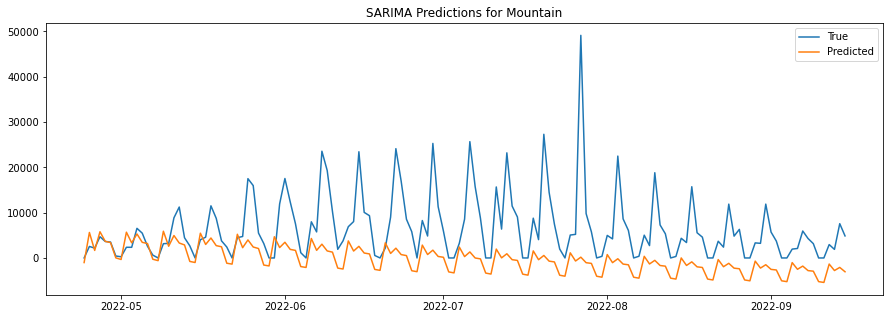


Training model for New England...
MAE: 3735.56
MSE: 19868236.99
RMSE: 4457.38
MASE: 1.5


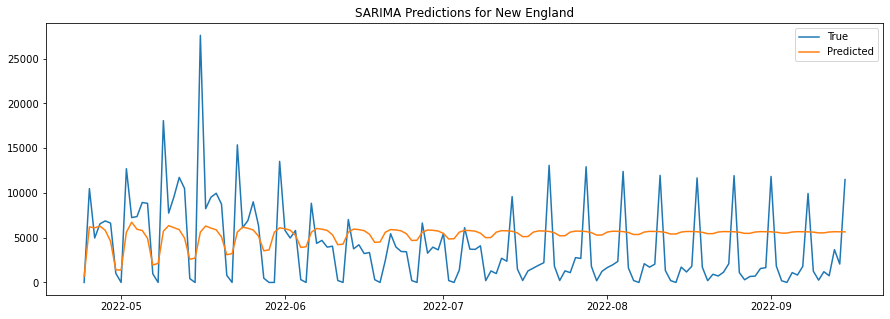


Training model for Pacific...
MAE: 14579.44
MSE: 382284225.78
RMSE: 19552.09
MASE: 2.18


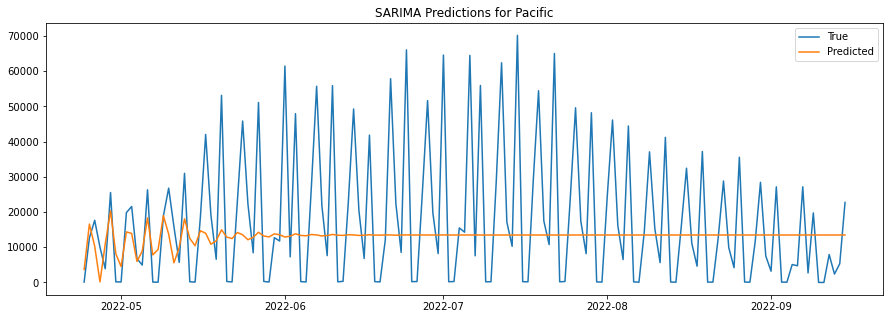


Training model for South Atlantic...
MAE: 15189.64
MSE: 482150135.6
RMSE: 21957.92
MASE: 1.46


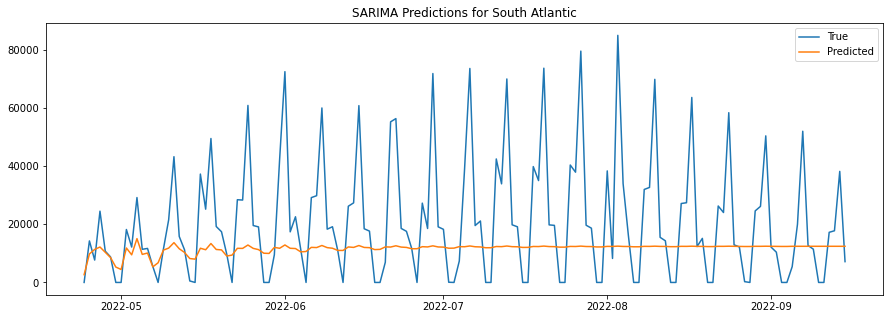


Training model for West North Central...
MAE: 6670.25
MSE: 62188947.9
RMSE: 7886.0
MASE: 2.13


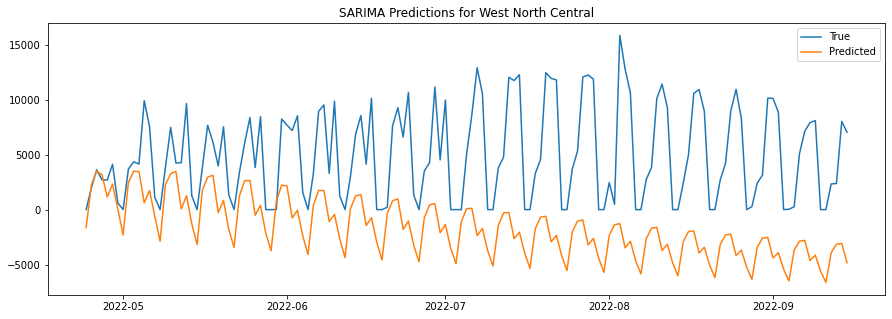


Training model for West South Central...
MAE: 11687.87
MSE: 211867097.0
RMSE: 14555.66
MASE: 2.65


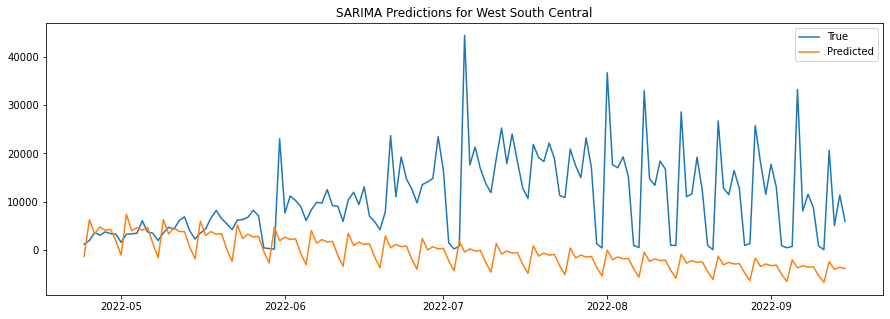


--- 287.89 seconds ---


In [24]:
start_time = time.time()
for df in datasets:
    region = [df["region"].iloc[0]][0]
    build_sarima_model(df, params=params[region], seasonal_params=seasonal_params[region], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")